# Stable Signature - Generate Watermarked Images

### Imports and setup

In [1]:
import argparse
import json
import os
import sys
from copy import deepcopy
from omegaconf import OmegaConf
from pathlib import Path
from typing import Callable, Iterable

import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image

import utils
import utils_img
import utils_model

sys.path.append('src')
from ldm.models.autoencoder import AutoencoderKL
from ldm.models.diffusion.ddpm import LatentDiffusion
from loss.loss_provider import LossProvider

import gc         # garbage collect library

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"


/home/ruixin/anaconda3/envs/stable-signature/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module 'xformers'. Proceeding without it.


In [4]:
def clear_memory():
    '''
    Delete unused tensors on GPU to reduce OOM issues. 
    '''
    try: 
        del ldm_decoder
    except: 
        pass
    try:
        del ldm_ae
    except:
        pass
    try:
        del msg_extractor
    except: 
        pass
    try: 
        del img
    except:
        pass
    try: 
        del imgs
    except:
        pass
    try: 
        del targets
    except:
        pass
    gc.collect()
    torch.cuda.empty_cache()

clear_memory()

### Load pretrained LDM 

Load the pretrained Stable Diffusion model [configuration](https://github.com/Stability-AI/stablediffusion/blob/main/configs/stable-diffusion/v2-inference.yaml) and [checkpoint](
https://huggingface.co/stabilityai/stable-diffusion-2-1-base/blob/main/v2-1_512-ema-pruned.ckpt).


In [5]:
ldm_config = "sd/v2-inference.yaml"
ldm_ckpt = "sd/v2-1_512-ema-pruned.ckpt"
config = OmegaConf.load(f"{ldm_config}")
ldm_ae: LatentDiffusion = utils_model.load_model_from_config(config, ldm_ckpt)
ldm_ae: AutoencoderKL = ldm_ae.first_stage_model
ldm_ae.eval()
ldm_ae.to(device)


Loading model from sd/v2-1_512-ema-pruned.ckpt
Global Step: 220000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 865.91 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
  

### Create dataloader

Images are loaded from the given directory, then resized (256x256) and cropped to standardize image. 

In [6]:
img_size = 256
val_dir = 'data/val'
train_dir = 'data/train'
batch_size = 1     # batch size = 1 to output single images
key = "key20"
key_dir = f'data/{key}'

vqgan_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    utils_img.normalize_vqgan,
    ])

key_loader = utils.get_dataloader(key_dir, vqgan_transform, batch_size, num_imgs=100, shuffle=False, num_workers=4, collate_fn=None)
#train_loader = utils.get_dataloader(train_dir, vqgan_transform, batch_size, num_imgs=500, shuffle=False, num_workers=4, collate_fn=None)
#val_loader = utils.get_dataloader(val_dir, vqgan_transform, batch_size, num_imgs=1000, shuffle=False, num_workers=4, collate_fn=None)
vqgan_to_imnet = transforms.Compose([utils_img.unnormalize_vqgan, utils_img.normalize_img])


### Load decoder

Copies the pretrained autoencoder and replaces the weights of the decoder with the finetuned decoder that had been generated using the code: 

`python finetune_ldm_decoder.py --train_dir data/train --val_dir data/val --batch_size 1 --output_dir keyX --seed X`

where X is an integer. Check the output of the load_state_dict method to ensure that there is no error with loading the decoder (incompatible encoder keys and quant_conv are fine). 

In [5]:
ldm_decoder = deepcopy(ldm_ae)
#state_dict = torch.load("/ssd/watermarks/stable_signature/sd/sd2_decoder.pth")
state_dict = torch.load(f"/ssd/watermarks/stable_signature/keys/{key}/checkpoint_000.pth")['ldm_decoder']

msg = ldm_decoder.load_state_dict(state_dict, strict=False)
#ldm_decoder.encoder = nn.Identity()
#ldm_decoder.quant_conv = nn.Identity()
assert(not any(["decoder" in x for x in msg.missing_keys]))
print(msg)

_IncompatibleKeys(missing_keys=['encoder.conv_in.weight', 'encoder.conv_in.bias', 'encoder.down.0.block.0.norm1.weight', 'encoder.down.0.block.0.norm1.bias', 'encoder.down.0.block.0.conv1.weight', 'encoder.down.0.block.0.conv1.bias', 'encoder.down.0.block.0.norm2.weight', 'encoder.down.0.block.0.norm2.bias', 'encoder.down.0.block.0.conv2.weight', 'encoder.down.0.block.0.conv2.bias', 'encoder.down.0.block.1.norm1.weight', 'encoder.down.0.block.1.norm1.bias', 'encoder.down.0.block.1.conv1.weight', 'encoder.down.0.block.1.conv1.bias', 'encoder.down.0.block.1.norm2.weight', 'encoder.down.0.block.1.norm2.bias', 'encoder.down.0.block.1.conv2.weight', 'encoder.down.0.block.1.conv2.bias', 'encoder.down.0.downsample.conv.weight', 'encoder.down.0.downsample.conv.bias', 'encoder.down.1.block.0.norm1.weight', 'encoder.down.1.block.0.norm1.bias', 'encoder.down.1.block.0.conv1.weight', 'encoder.down.1.block.0.conv1.bias', 'encoder.down.1.block.0.norm2.weight', 'encoder.down.1.block.0.norm2.bias', 'e

### Generate images

Generate images watermarked with a given key. Use the next section on "Stable Signature - Decoding" to verify if the watermarked images were correctly generated. 

In [11]:
def generate_images(img_loader, output_dir, ldm_ae, ldm_decoder, header):
    '''
    Generate images by: 
    1. Encoding images using the pretrained stable diffusion encoder ldm_ae
    2. Decoding it using the ldm_decoder to generate images with a watermark
    3. Decoding it with the original decoder in ldm_ae generate images without 
       the watermark 
    4. Apply transformations to augment the original, watermarked, and decoded 
       (non-watermarked) images
    5. Output the watermarked image to output_dir. 
    
    Params: 
        img_loader: a dataloader loads images from a specified directory
        output_dir: directory to output the generated images
        ldm_ae: pretrained stable diffusion autoencoder
        ldm_decoder: finetuned decoder to generate images with a specific watermark
        header: identifier to name images generated by the specific ldm_decoder
    '''
    ldm_decoder.decoder.eval()
    for ii, imgs in enumerate(tqdm.tqdm(img_loader)):
        imgs = imgs.to(device)
    
        imgs_z = ldm_ae.encode(imgs) 
        imgs_z = imgs_z.mode()

        imgs_d0 = ldm_ae.decode(imgs_z) 
        imgs_w = ldm_decoder.decode(imgs_z) 

        attacks = {
                'none': lambda x: x,
                'crop_01': lambda x: utils_img.center_crop(x, 0.1),
                'crop_05': lambda x: utils_img.center_crop(x, 0.5),
                'rot_25': lambda x: utils_img.rotate(x, 25),
                'rot_90': lambda x: utils_img.rotate(x, 90),
                'resize_03': lambda x: utils_img.resize(x, 0.3),
                'resize_07': lambda x: utils_img.resize(x, 0.7),
                'brightness_1p5': lambda x: utils_img.adjust_brightness(x, 1.5),
                'brightness_2': lambda x: utils_img.adjust_brightness(x, 2),
                'jpeg_80': lambda x: utils_img.jpeg_compress(x, 80),
                'jpeg_50': lambda x: utils_img.jpeg_compress(x, 50),
                }
        for name, attack in attacks.items():
            imgs_aug = attack(vqgan_to_imnet(imgs))
            save_image(torch.clamp(utils_img.unnormalize_vqgan(imgs_aug),0,1), os.path.join(output_dir, f'{header}_{ii:03}_{name}_orig.png'), nrow=1)
            imgs_aug = attack(vqgan_to_imnet(imgs_w))
            save_image(torch.clamp(utils_img.unnormalize_vqgan(imgs_aug),0,1), os.path.join(output_dir, f'{header}_{ii:03}_{name}_w.png'), nrow=1)
            imgs_aug = attack(vqgan_to_imnet(imgs_d0))
            save_image(torch.clamp(utils_img.unnormalize_vqgan(imgs_aug),0,1), os.path.join(output_dir, f'{header}_{ii:03}_{name}_d0.png'), nrow=1)

#generate_images(val_loader, "data/watermarked-val", ldm_ae, ldm_decoder, key)

### Generate images with different watermarks 

Generate the train and val datasets used to train the watermark classifier. Each dataset comprises original images, generated images, and watermarked images of different different keys. Transformations (e.g. rotate, crop) are applied to augment the datasets. 

In [ ]:
def generate_ds(output_dir, start_keys_idx, end_keys_idx, ckpt_path, num_imgs=100):
    for i in range(start_keys_idx, end_keys_idx):
        key = f"key{i}"
        key_dir = f'data/{key}'
        state_dict = torch.load(f"/ssd/watermarks/stable_signature/keys/{key}/checkpoint_000.pth")['ldm_decoder']
        msg = ldm_decoder.load_state_dict(state_dict, strict=False)
        assert(not any(["decoder" in x for x in msg.missing_keys]))
        img_loader = utils.get_dataloader(key_dir, vqgan_transform, batch_size, num_imgs=num_imgs, shuffle=True, num_workers=4, collate_fn=None)
        generate_images(img_loader, output_dir, ldm_ae, ldm_decoder, key)

ckpt_path = f"/ssd/watermarks/stable_signature/keys/{key}/checkpoint_000.pth"
generate_ds("data/watermarked", 1, 11, ckpt_path)
generate_ds("data/watermarked-val", 11, 21, ckpt_path)

Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Stable Signature - Decoding

Each model has its own key, which can be found in the `keys.txt` file when the fine-tuning is done. 
The key is a string of 48 bits, which can be converted to a boolean array of 48 elements. 
The `msg_extractor` is a TorchScript model that extracts the message from the image.

Based on the number of matching bits between the key and the message, the image can be classified as genuine or generated by our model.

### Imports and setup

In [1]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def msg2str(msg):
    return "".join([('1' if el else '0') for el in msg])

def str2msg(str):
    return [True if el=='1' else False for el in str]

msg_extractor = torch.jit.load("models/dec_48b_whit.torchscript.pt").to("cuda")
transform_imnet = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

/home/ruixin/anaconda3/envs/stable-signature/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Decode images

In [3]:
# Verify that watermarks were generated correctly 
img = Image.open("/ssd/watermarks/stable_signature/data/watermarked/key1_004_none_w.png")
#img = Image.open("/ssd/watermarks/stable_signature/key1/imgs/key1_054_none_w.png")
img = transform_imnet(img).unsqueeze(0).to("cuda")
msg = msg_extractor(img) # b c h w -> b k
bool_msg = (msg>0).squeeze().cpu().numpy().tolist()
print("Extracted message: ", msg2str(bool_msg))

Extracted message:  001101111100110001100010001100010011000010110011


### Compute bit accuracies and run statistical test

Metrics are:
- **Bit accuracy**: number of matching bits between the key and the message, divided by the total number of bits.
- **$p$-value**: probability of observing a bit accuracy as high as the one observed, assuming the null hypothesis that the image is genuine.

In [4]:
#key = '111010110101000001010111010011010100010000100111' # model key
key = '001100111100110001100010001100010011000010111111'
bool_key = str2msg(key)

# compute difference between model key and message extracted from image
diff = [bool_msg[i] != bool_key[i] for i in range(len(bool_msg))]
bit_acc = 1 - sum(diff)/len(diff)
print("Bit accuracy: ", bit_acc)

# compute p-value
from scipy.stats import binomtest
pval = binomtest(len(diff)-sum(diff), len(diff), 0.5, alternative='greater')
print("p-value of statistical test: ", pval)

Bit accuracy:  0.9375
p-value of statistical test:  BinomTestResult(k=45, n=48, alternative='greater', proportion_estimate=0.9375, pvalue=6.562927978848165e-11)


Typically, one can set a threshold $\tau$ on the bit accuracy to classify an image as genuine or generated.
Here is the table of FPRs for different thresholds on bit accuracy.

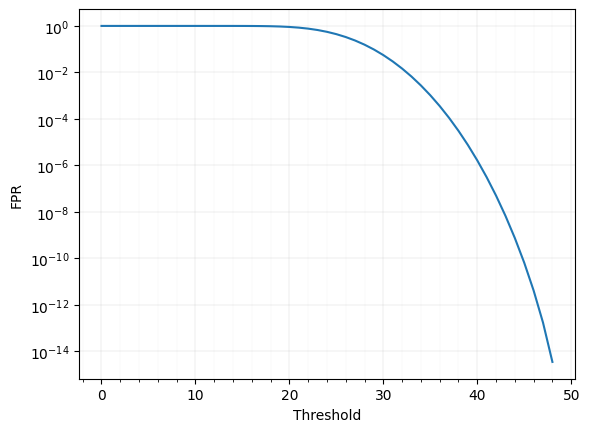

In [5]:
from scipy.stats import binom
import numpy as np
import matplotlib.pyplot as plt

def fpr(threshold, n):
    return binom.cdf(n-threshold, n, 0.5)

thresholds = np.linspace(0, 48, 49)
fprs = [fpr(threshold, 48) for threshold in thresholds]

plt.plot(thresholds, fprs)
plt.yscale("log")
plt.xlabel("Threshold")
plt.ylabel("FPR")

plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.2, alpha=0.8)
plt.grid(axis='both', which='minor', linestyle='-', linewidth=0.1, alpha=0.5)

plt.show()

# Watermark Detector

The detector is trained to classify if an image has a watermark that was generated using the stable signature method. Currently only tested on 48-bit watermarks. 

In [12]:
from torch.utils.data import DataLoader, Subset
from torchvision.datasets.folder import default_loader
from torch.nn.utils.rnn import pad_sequence

batch_size = 8
train_dir = "data/watermarked"
train_size = 33000
val_dir = "data/watermarked-val"
val_size = 1000

class ImageFolder:
    """An image folder dataset intended for supervised learning."""

    def __init__(self, path, transform=None, loader=default_loader):
        self.samples = utils.get_image_paths(path)
        self.loader = loader
        self.transform = transform

    def __getitem__(self, idx: int):
        """
        Returns the image with its corresponding label. Images are 
        labeled 0 if the image is not watermarked, else 1. 
        """
        assert 0 <= idx < len(self)
        path = self.samples[idx]
        img = self.loader(path)
        label = 0 if "orig" in path or "d0" in path else 1
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.samples)


def get_dataloader(data_dir, transform, batch_size=128, num_imgs=None, shuffle=False, num_workers=4, collate_fn=None):
    """ Get dataloader for the images in the data_dir. The data_dir must be of the form: input/0/... """
    dataset = ImageFolder(data_dir, transform=transform)
    if num_imgs is not None:
        dataset = Subset(dataset, np.random.choice(len(dataset), num_imgs, replace=False))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True, drop_last=False, collate_fn=collate_fn)

train_loader = get_dataloader(train_dir, vqgan_transform, batch_size, num_imgs=train_size, shuffle=True, num_workers=4, collate_fn=None)
val_loader = get_dataloader(val_dir, vqgan_transform, 2, num_imgs=val_size, shuffle=True, num_workers=4, collate_fn=None)


### Create model

Replace the last layer of the [pretrained watermark extractor](https://dl.fbaipublicfiles.com/ssl_watermarking/dec_48b_whit.torchscript.pt) with a fully connected layer comprising one neuron. 

In [15]:
msg_extractor = torch.jit.load("models/dec_48b_whit.torchscript.pt").to("cpu")

model = nn.Sequential(
    nn.Sequential(*(list(msg_extractor.children())[:-1])),
    nn.Dropout(p=0.1),
    nn.Linear(in_features=48, out_features=1)
)

for param in model.parameters():
    param.requires_grad = True
    
model

Sequential(
  (0): Sequential(
    (0): RecursiveScriptModule(
      original_name=HiddenDecoder
      (layers): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=ConvBNRelu
          (layers): RecursiveScriptModule(
            original_name=Sequential
            (0): RecursiveScriptModule(original_name=Conv2d)
            (1): RecursiveScriptModule(original_name=BatchNorm2d)
            (2): RecursiveScriptModule(original_name=GELU)
          )
        )
        (1): RecursiveScriptModule(
          original_name=ConvBNRelu
          (layers): RecursiveScriptModule(
            original_name=Sequential
            (0): RecursiveScriptModule(original_name=Conv2d)
            (1): RecursiveScriptModule(original_name=BatchNorm2d)
            (2): RecursiveScriptModule(original_name=GELU)
          )
        )
        (2): RecursiveScriptModule(
          original_name=ConvBNRelu
          (layers): RecursiveScriptModule(

Alternatively, load model if previously saved. 

In [7]:
model = torch.jit.load("models/watermark_classifier.pt").to(device)

### Train model

In [16]:
from sklearn.metrics import confusion_matrix

def train(model, data_loader, dataset_size, criterion, optimizer, scheduler, epoch):
    """
    Train model using the data_loader for 1 epoch. Prints out a confusion matrix,
    loss, and accuracy every 100 steps and at the end of the epoch.
    """
    model.train()
    pred_len = 0
    y_pred = []
    y_true = []
    test_correct = 0

    running_loss = 0.0
    # Iterate over data.
    for step, data in enumerate(tqdm.tqdm(data_loader)):
        clear_memory()
        inputs, labels = data
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            targets = labels.unsqueeze(1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            preds = torch.sigmoid(outputs).round().cpu().detach().numpy().squeeze()
            y_pred.extend(preds)
            labels = labels.cpu().numpy()
            y_true.extend(labels)
            test_correct += int((preds == labels).sum())
            pred_len += preds.size
            if step%100 == 0:
                print(f'Step: {step}, Loss:  {loss.item():.4f}, Acc: {test_correct/pred_len}')
                cf_matrix = confusion_matrix(y_true, y_pred)
                print(cf_matrix)

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / dataset_size
    print(f'Epoch: {epoch}, Loss: {epoch_loss:.4f}, Acc: {test_correct/pred_len}')
    cf_matrix = confusion_matrix(y_true, y_pred)
    print(cf_matrix)
    scheduler.step()
    return model 
    
def validate(model, data_loader, dataset_size, criterion):
    """
    Validates model using the data_loader. Prints out a confusion matrix,
    loss, and accuracy every 100 steps and at the end.
    """
    model.eval()
    pred_len = 0
    y_pred = []
    y_true = []
    test_correct = 0

    running_loss = 0.0
    # Iterate over data.
    for step, d in enumerate(tqdm.tqdm(data_loader)):
        clear_memory()
        inputs, labels = d
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            targets = labels.unsqueeze(1)
            loss = criterion(outputs, targets)
            preds = torch.sigmoid(outputs).round().cpu().detach().numpy().squeeze()
            y_pred.extend(preds)
            labels = labels.cpu().numpy()
            y_true.extend(labels)
            test_correct += int((preds == labels).sum())
            pred_len += preds.size
            if step%100 == 0:
                print(f'Step: {step}, Loss:  {loss.item():.4f}, Acc: {test_correct/pred_len}')
                cf_matrix = confusion_matrix(y_true, y_pred)
                print(cf_matrix)

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / dataset_size
    print(f'Val Loss: {epoch_loss:.4f}, Val Acc: {test_correct/pred_len}')
    cf_matrix = confusion_matrix(y_true, y_pred)
    print(cf_matrix)


def train_model(model, train_loader, train_size, val_loader, val_size, criterion, optimizer, scheduler, num_epochs):
    """
    Runs train and validate for num_epochs. 
    """
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        model = train(model, train_loader, train_size, criterion, optimizer, scheduler, epoch)
        clear_memory()
        validate(model, val_loader, val_size, criterion)
        return model  


In [17]:
import torch.optim as optim
from torch.optim import lr_scheduler

model = model.to(device)
clear_memory()
criterion = nn.BCEWithLogitsLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
lr_sch = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

model = train_model(model, train_loader, train_size, val_loader, val_size, criterion, optimizer_ft, lr_sch, 1)


Epoch 0/0
----------


  0%|                                                                                                                                                                      | 1/4125 [00:00<45:52,  1.50it/s]

Step: 0, Loss:  1.6486, Acc: 0.5
[[3 2]
 [2 1]]


  2%|████                                                                                                                                                                | 101/4125 [00:44<29:23,  2.28it/s]

Step: 100, Loss:  0.8124, Acc: 0.7871287128712872
[[466  76]
 [ 96 170]]


  5%|███████▉                                                                                                                                                            | 201/4125 [01:28<29:02,  2.25it/s]

Step: 200, Loss:  0.0513, Acc: 0.8072139303482587
[[929 134]
 [176 369]]


  7%|███████████▉                                                                                                                                                        | 301/4125 [02:12<28:21,  2.25it/s]

Step: 300, Loss:  0.4475, Acc: 0.8201827242524917
[[1413  186]
 [ 247  562]]


 10%|███████████████▉                                                                                                                                                    | 401/4125 [02:56<27:42,  2.24it/s]

Step: 400, Loss:  0.3309, Acc: 0.8397755610972568
[[1914  211]
 [ 303  780]]


 12%|███████████████████▉                                                                                                                                                | 501/4125 [03:41<26:50,  2.25it/s]

Step: 500, Loss:  0.0409, Acc: 0.8532934131736527
[[2423  239]
 [ 349  997]]


 15%|███████████████████████▉                                                                                                                                            | 601/4125 [04:25<26:33,  2.21it/s]

Step: 600, Loss:  0.5300, Acc: 0.8612728785357737
[[2903  272]
 [ 395 1238]]


 17%|███████████████████████████▊                                                                                                                                        | 701/4125 [05:10<25:29,  2.24it/s]

Step: 700, Loss:  0.2528, Acc: 0.865549215406562
[[3397  309]
 [ 445 1457]]


 19%|███████████████████████████████▊                                                                                                                                    | 801/4125 [05:54<24:47,  2.23it/s]

Step: 800, Loss:  0.1270, Acc: 0.8671972534332085
[[3897  344]
 [ 507 1660]]


 22%|███████████████████████████████████▊                                                                                                                                | 901/4125 [06:39<24:02,  2.23it/s]

Step: 900, Loss:  0.2779, Acc: 0.8734739178690344
[[4429  365]
 [ 547 1867]]


 24%|███████████████████████████████████████▌                                                                                                                           | 1001/4125 [07:23<23:50,  2.18it/s]

Step: 1000, Loss:  0.4366, Acc: 0.8778721278721279
[[4934  388]
 [ 590 2096]]


 27%|███████████████████████████████████████████▌                                                                                                                       | 1101/4125 [08:08<23:05,  2.18it/s]

Step: 1100, Loss:  0.0550, Acc: 0.8815849227974568
[[5452  414]
 [ 629 2313]]


 29%|███████████████████████████████████████████████▍                                                                                                                   | 1201/4125 [08:53<22:05,  2.21it/s]

Step: 1200, Loss:  0.0582, Acc: 0.8859283930058285
[[5962  430]
 [ 666 2550]]


 32%|███████████████████████████████████████████████████▍                                                                                                               | 1301/4125 [09:37<21:15,  2.21it/s]

Step: 1300, Loss:  0.0397, Acc: 0.8899884704073789
[[6480  444]
 [ 701 2783]]


 34%|███████████████████████████████████████████████████████▎                                                                                                           | 1401/4125 [10:22<20:35,  2.20it/s]

Step: 1400, Loss:  0.1752, Acc: 0.89302284082798
[[6982  461]
 [ 738 3027]]


 36%|███████████████████████████████████████████████████████████▎                                                                                                       | 1501/4125 [11:06<19:42,  2.22it/s]

Step: 1500, Loss:  0.5814, Acc: 0.894653564290473
[[7505  486]
 [ 779 3238]]


 39%|███████████████████████████████████████████████████████████████▎                                                                                                   | 1601/4125 [11:51<19:14,  2.19it/s]

Step: 1600, Loss:  0.0980, Acc: 0.8977201748906933
[[8041  496]
 [ 814 3457]]


 41%|███████████████████████████████████████████████████████████████████▏                                                                                               | 1701/4125 [12:36<18:25,  2.19it/s]

Step: 1700, Loss:  0.1238, Acc: 0.9006466784244562
[[8526  511]
 [ 841 3730]]


 44%|███████████████████████████████████████████████████████████████████████▏                                                                                           | 1801/4125 [13:21<17:25,  2.22it/s]

Step: 1800, Loss:  0.0083, Acc: 0.9029705719044975
[[9035  526]
 [ 872 3975]]


 46%|███████████████████████████████████████████████████████████████████████████                                                                                        | 1901/4125 [14:06<17:02,  2.17it/s]

Step: 1900, Loss:  0.1870, Acc: 0.9058390320883746
[[9563  538]
 [ 894 4213]]


 49%|███████████████████████████████████████████████████████████████████████████████                                                                                    | 2001/4125 [14:51<16:13,  2.18it/s]

Step: 2000, Loss:  0.0184, Acc: 0.907983508245877
[[10088   552]
 [  921  4447]]


 51%|███████████████████████████████████████████████████████████████████████████████████                                                                                | 2101/4125 [15:36<15:33,  2.17it/s]

Step: 2100, Loss:  0.0204, Acc: 0.9096263683960019
[[10609   568]
 [  951  4680]]


 53%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 2201/4125 [16:20<14:45,  2.17it/s]

Step: 2200, Loss:  0.0037, Acc: 0.9116878691503862
[[11112   582]
 [  973  4941]]


 56%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 2301/4125 [17:05<14:05,  2.16it/s]

Step: 2300, Loss:  0.0056, Acc: 0.9141134289439374
[[11656   588]
 [  993  5171]]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 2401/4125 [17:51<13:15,  2.17it/s]

Step: 2400, Loss:  0.0016, Acc: 0.9160766347355269
[[12182   596]
 [ 1016  5414]]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2501/4125 [18:36<13:03,  2.07it/s]

Step: 2500, Loss:  0.1106, Acc: 0.9174330267892843
[[12707   610]
 [ 1042  5649]]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2601/4125 [19:22<11:52,  2.14it/s]

Step: 2600, Loss:  0.1464, Acc: 0.9183006535947712
[[13212   629]
 [ 1071  5896]]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2701/4125 [20:07<11:07,  2.13it/s]

Step: 2700, Loss:  0.0402, Acc: 0.9195205479452054
[[13738   639]
 [ 1100  6131]]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2801/4125 [20:53<10:21,  2.13it/s]

Step: 2800, Loss:  0.0138, Acc: 0.9204302034987505
[[14230   651]
 [ 1132  6395]]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2901/4125 [21:38<09:30,  2.15it/s]

Step: 2900, Loss:  0.0571, Acc: 0.9211909686315064
[[14741   666]
 [ 1163  6638]]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3001/4125 [22:24<08:48,  2.13it/s]

Step: 3000, Loss:  0.1624, Acc: 0.9217344218593803
[[15267   685]
 [ 1194  6862]]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3101/4125 [23:09<07:59,  2.14it/s]

Step: 3100, Loss:  0.0243, Acc: 0.9226459206707514
[[15795   696]
 [ 1223  7094]]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 3201/4125 [23:54<07:15,  2.12it/s]

Step: 3200, Loss:  0.0238, Acc: 0.9235785691971259
[[16320   712]
 [ 1245  7331]]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3301/4125 [24:40<06:34,  2.09it/s]

Step: 3300, Loss:  0.1174, Acc: 0.9245683126325356
[[16855   720]
 [ 1272  7561]]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 3401/4125 [25:26<05:39,  2.13it/s]

Step: 3400, Loss:  0.2051, Acc: 0.9260879153190238
[[17407   726]
 [ 1285  7790]]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 3501/4125 [26:11<04:58,  2.09it/s]

Step: 3500, Loss:  0.0047, Acc: 0.9268423307626392
[[17929   742]
 [ 1307  8030]]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 3601/4125 [26:57<04:10,  2.10it/s]

Step: 3600, Loss:  0.1351, Acc: 0.927797833935018
[[18473   750]
 [ 1330  8255]]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 3701/4125 [27:43<03:20,  2.11it/s]

Step: 3700, Loss:  0.1616, Acc: 0.9291069981086193
[[18998   756]
 [ 1343  8511]]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3801/4125 [28:29<02:34,  2.09it/s]

Step: 3800, Loss:  0.0005, Acc: 0.9301828466193107
[[19522   766]
 [ 1357  8763]]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3901/4125 [29:14<01:46,  2.11it/s]

Step: 3900, Loss:  0.0138, Acc: 0.931427839015637
[[20063   772]
 [ 1368  9005]]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4001/4125 [30:00<00:59,  2.10it/s]

Step: 4000, Loss:  0.0134, Acc: 0.9319857535616096
[[20563   785]
 [ 1392  9268]]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 4101/4125 [30:45<00:11,  2.06it/s]

Step: 4100, Loss:  0.0090, Acc: 0.9319068519873202
[[21061   809]
 [ 1425  9513]]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4125/4125 [30:56<00:00,  2.22it/s]


Epoch: 0, Loss: 0.1849, Acc: 0.931969696969697
[[21188   812]
 [ 1433  9567]]


  0%|▋                                                                                                                                                                      | 2/500 [00:00<01:19,  6.28it/s]

Step: 0, Loss:  0.1365, Acc: 1.0
[[2]]


 20%|█████████████████████████████████▋                                                                                                                                   | 102/500 [00:13<00:51,  7.73it/s]

Step: 100, Loss:  2.3708, Acc: 0.9108910891089109
[[136  11]
 [  7  48]]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                  | 202/500 [00:26<00:38,  7.72it/s]

Step: 200, Loss:  0.0158, Acc: 0.8980099502487562
[[235  30]
 [ 11 126]]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 302/500 [00:39<00:25,  7.71it/s]

Step: 300, Loss:  0.0199, Acc: 0.9053156146179402
[[352  42]
 [ 15 193]]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 402/500 [00:52<00:12,  7.75it/s]

Step: 400, Loss:  0.0682, Acc: 0.9064837905236908
[[469  56]
 [ 19 258]]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:05<00:00,  7.68it/s]

Val Loss: 0.2593, Val Acc: 0.907
[[587  70]
 [ 23 320]]


### Save model

In [18]:
jit_model = torch.jit.script(model)
torch.jit.save(jit_model, "models/watermark_classifier.pt")

# Watermark Remover

Create a watermark remover by refining the LDM decoder. 

In [15]:
from torch.utils.data import DataLoader, Subset
from torchvision.datasets.folder import default_loader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable


val_dir = 'data/watermarked-val'
train_dir = 'data/watermarked'
train_size = 11000
#train_size = 2000
val_size = 1000
batch_size = 2


class ImageFolder:
    """An image folder dataset intended for supervised learning."""

    def __init__(self, path, transform=None, loader=default_loader):
        # ignore generated images without a watermark 
        self.samples = [x for x in utils.get_image_paths(path) if "orig" in x]
        self.loader = loader
        self.transform = transform

    def __getitem__(self, idx: int):
        assert 0 <= idx < len(self)
        path = self.samples[idx]
        
        img = None
        watermarked_img = None
        img = self.loader(path)
        path_w = path.replace("_orig", "_w")
        watermarked_img = self.loader(path_w)

        if self.transform:
            img = self.transform(img)
            watermarked_img = self.transform(watermarked_img)
            return img, watermarked_img

    def __len__(self):
        return len(self.samples)
    
    
def get_dataloader(data_dir, transform, batch_size=128, num_imgs=None, shuffle=False, num_workers=4, collate_fn=None):
    """ Get dataloader for the images in the data_dir. The data_dir must be of the form: input/0/... """
    dataset = ImageFolder(data_dir, transform=transform)
    if num_imgs is not None:
        dataset = Subset(dataset, np.random.choice(len(dataset), num_imgs, replace=False))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True, drop_last=False, collate_fn=collate_fn)

train_loader = get_dataloader(train_dir, vqgan_transform, batch_size, num_imgs=train_size, shuffle=True, num_workers=4, collate_fn=None)
val_loader = get_dataloader(val_dir, vqgan_transform, batch_size, num_imgs=val_size, shuffle=True, num_workers=4, collate_fn=None)


### Create model

Define models, loss, criterion, optimizer, and learning rate scheduler. Uses perceptual loss in this case, which is a loss function that measures the difference between the high-level features of two images.
Loads existing model in "models/checkpoint.pt" and optimizer state if it exists. 

In [16]:
from loss.loss_provider import LossProvider
provider = LossProvider()
loss_percep = provider.get_loss_function('Watson-VGG', colorspace='RGB', pretrained=True, reduction='sum')
loss_percep = loss_percep.to(device)
loss_i = lambda imgs_w, imgs: loss_percep((1+imgs_w)/2.0, (1+imgs)/2.0)/ imgs_w.shape[0]


In [17]:
watermark_classifier = torch.jit.load("models/watermark_classifier.pt").to(device)
model = deepcopy(ldm_ae)
ldm_ae.to("cpu")

for param in model.encoder.parameters():
    param.requires_grad = False
    
for param in model.decoder.parameters():
    param.requires_grad = True
    
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_sch = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
  

Load model from checkpoint if it exists

In [10]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

model, optimizer, start_epoch = load_ckp("models/checkpoint.pt", model, optimizer)

In [18]:
def debug_memory():
    """
    Helper function to debug GPU memory leak. 
    """
    import collections, gc, resource, torch
    print('maxrss = {}'.format(
        resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
    tensors = collections.Counter(
        (str(o.device), str(o.dtype), tuple(o.shape))
        for o in gc.get_objects()
        if torch.is_tensor(o)
    )
    for line in sorted(tensors.items()):
        print('{}\t{}'.format(*line))
#debug_memory()

In [19]:
def save_ckp(state, checkpoint_dir):
    f_path = f'{checkpoint_dir}/checkpoint.pt'
    torch.save(state, f_path)

### Train model

In [20]:
def train(model, watermark_classifier, data_loader, dataset_size, criterion, optimizer, scheduler, epoch):
    model.decoder.train()
    pred_len = 0
    y_pred = []
    y_true = []
    test_correct = 0
    # label the ground truth for the output image as non-watermarked
    targets = Variable(torch.Tensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

    running_loss = 0.0
    # Iterate over data.
    for step, (imgs, imgs_w) in enumerate(tqdm.tqdm(data_loader)):
        clear_memory()
        imgs = imgs.to(device, dtype=torch.float)
        imgs_w = imgs_w.to(device, dtype=torch.float)
        optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(True):
            
            # encode watermarked images
            imgs_z = model.encode(imgs_w) 
            imgs_z = imgs_z.mode()
            #print(torch.cuda.memory_allocated()/ torch.cuda.max_memory_allocated())
            outputs = model.decode(imgs_z)
            watermark_pred = watermark_classifier(outputs)
            # compute loss against non-watermarked imgs
            lossi = loss_i(outputs, imgs)
            lossw = criterion(watermark_pred, targets)
            # somewhat arbitrary selection of loss weights 
            loss = 0.2 * lossw + 0.8 * lossi
            loss.backward()
            optimizer.step()
            
            preds = torch.sigmoid(watermark_pred).round().cpu().detach().numpy().squeeze()
            y_pred.extend(preds)
            labels = targets.cpu().numpy().squeeze()
            y_true.extend(labels)
            test_correct += int((preds == labels).sum())
            pred_len += preds.size
            if step%100 == 0:
                # Save the outpt
                print(f'Step: {step}, Loss:  {loss.item():.4f}, Acc: {test_correct/pred_len}')
                save_image(torch.clamp(utils_img.unnormalize_vqgan(imgs),0,1), os.path.join(f'{step:03}_train_orig.png'), nrow=8)
                save_image(torch.clamp(utils_img.unnormalize_vqgan(outputs),0,1), os.path.join(f'{step:03}_train_removed.png'), nrow=8)
                save_image(torch.clamp(utils_img.unnormalize_vqgan(imgs_w),0,1), os.path.join(f'{step:03}_train_w.png'), nrow=8)
                checkpoint = {
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }
                save_ckp(checkpoint, "models/")

        running_loss += loss.item() * imgs.size(0)
        del imgs, imgs_w, imgs_z, outputs, watermark_pred
    epoch_loss = running_loss / dataset_size
    print(f'Epoch: {epoch}, Loss: {epoch_loss:.4f}, Watermark Detection Acc: {test_correct/pred_len}')
    scheduler.step()
    return model 

def validate(model, watermark_classifier, data_loader, dataset_size, criterion):
    model.decoder.eval()
    pred_len = 0
    y_pred = []
    y_true = []
    test_correct = 0
    # Target t
    targets = Variable(torch.Tensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

    running_loss = 0.0
    # Iterate over data.
    for step, (imgs, imgs_w) in enumerate(tqdm.tqdm(data_loader)):
        #print(torch.cuda.memory_allocated()/ torch.cuda.max_memory_allocated())
        clear_memory()
        imgs = imgs.to(device, dtype=torch.float)
        imgs_w = imgs_w.to(device, dtype=torch.float)

        with torch.set_grad_enabled(False):

            # encode watermarked images
            imgs_z = model.encode(imgs_w) 
            imgs_z = imgs_z.mode()

            outputs = model.decode(imgs_z)
            watermark_pred = watermark_classifier(outputs)
            
            # compute loss against non-watermarked imgs
            lossi = loss_i(outputs, imgs)
            lossw = criterion(watermark_pred, targets)
            loss = 0.2 * lossw + 0.8 * lossi
            
            preds = torch.sigmoid(watermark_pred).round().cpu().detach().numpy().squeeze()
            y_pred.extend(preds)
            labels = targets.cpu().numpy().squeeze()
            y_true.extend(labels)
            test_correct += int((preds == labels).sum())
            pred_len += preds.size
            if step%100 == 0:
                print(f'Step: {step}, Loss:  {loss.item():.4f}, Acc: {test_correct/pred_len}')
                save_image(torch.clamp(utils_img.unnormalize_vqgan(imgs),0,1), os.path.join(f'{step:03}_val_orig.png'), nrow=8)
                save_image(torch.clamp(utils_img.unnormalize_vqgan(outputs),0,1), os.path.join(f'{step:03}_val_removed.png'), nrow=8)
                save_image(torch.clamp(utils_img.unnormalize_vqgan(imgs_w),0,1), os.path.join(f'{step:03}_val_w.png'), nrow=8)
        running_loss += loss.item() * imgs.size(0)
        del imgs, imgs_w, imgs_z, outputs, watermark_pred
    epoch_loss = running_loss / dataset_size
    print(f'Loss: {epoch_loss:.4f}, Watermark Detection Acc: {test_correct/pred_len}')
    return model 

def train_model(model, watermark_classifier, train_loader, train_size, val_loader, val_size, criterion, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        model = train(model, watermark_classifier, train_loader, train_size, criterion, optimizer, scheduler, epoch)
        clear_memory()
        validate(model, watermark_classifier, val_loader, val_size, criterion)
        return model  


In [21]:
clear_memory()
model = model.to(device)

model = train_model(model, watermark_classifier, train_loader, train_size, val_loader, val_size, criterion, optimizer, lr_sch, 1)


Epoch 0/0
----------


  0%|                                                                                                                                                                              | 0/5500 [00:00<?, ?it/s]

Step: 0, Loss:  3.9205, Acc: 0.5


  2%|██▉                                                                                                                                                               | 100/5500 [01:54<1:43:57,  1.16s/it]

Step: 100, Loss:  5.1525, Acc: 0.995049504950495


  4%|█████▉                                                                                                                                                            | 200/5500 [03:52<1:42:14,  1.16s/it]

Step: 200, Loss:  4.8955, Acc: 0.9975124378109452


  5%|████████▊                                                                                                                                                         | 300/5500 [05:49<1:40:44,  1.16s/it]

Step: 300, Loss:  4.3133, Acc: 0.9983388704318937


  7%|███████████▊                                                                                                                                                      | 400/5500 [07:47<1:38:38,  1.16s/it]

Step: 400, Loss:  5.0220, Acc: 0.9987531172069826


  9%|██████████████▋                                                                                                                                                   | 500/5500 [09:45<1:37:30,  1.17s/it]

Step: 500, Loss:  4.5820, Acc: 0.999001996007984


 11%|█████████████████▋                                                                                                                                                | 600/5500 [11:42<1:35:14,  1.17s/it]

Step: 600, Loss:  4.2274, Acc: 0.9991680532445923


 13%|████████████████████▌                                                                                                                                             | 700/5500 [13:40<1:33:00,  1.16s/it]

Step: 700, Loss:  5.0271, Acc: 0.9992867332382311


 15%|███████████████████████▌                                                                                                                                          | 800/5500 [15:38<1:31:22,  1.17s/it]

Step: 800, Loss:  4.0795, Acc: 0.9993757802746567


 16%|██████████████████████████▌                                                                                                                                       | 900/5500 [17:35<1:29:25,  1.17s/it]

Step: 900, Loss:  4.5220, Acc: 0.9994450610432852


 18%|█████████████████████████████▎                                                                                                                                   | 1000/5500 [19:33<1:27:34,  1.17s/it]

Step: 1000, Loss:  4.7022, Acc: 0.9995004995004995


 20%|████████████████████████████████▏                                                                                                                                | 1100/5500 [21:31<1:25:15,  1.16s/it]

Step: 1100, Loss:  4.6060, Acc: 0.9995458673932789


 22%|███████████████████████████████████▏                                                                                                                             | 1200/5500 [23:29<1:23:29,  1.16s/it]

Step: 1200, Loss:  4.3832, Acc: 0.9995836802664446


 24%|██████████████████████████████████████                                                                                                                           | 1300/5500 [25:26<1:21:34,  1.17s/it]

Step: 1300, Loss:  5.5058, Acc: 0.9996156802459646


 25%|████████████████████████████████████████▉                                                                                                                        | 1400/5500 [27:24<1:19:39,  1.17s/it]

Step: 1400, Loss:  4.7252, Acc: 0.9996431120628123


 27%|███████████████████████████████████████████▉                                                                                                                     | 1500/5500 [29:22<1:18:04,  1.17s/it]

Step: 1500, Loss:  3.8168, Acc: 0.9996668887408394


 29%|██████████████████████████████████████████████▊                                                                                                                  | 1600/5500 [31:20<1:15:31,  1.16s/it]

Step: 1600, Loss:  4.1222, Acc: 0.9996876951905059


 31%|█████████████████████████████████████████████████▊                                                                                                               | 1700/5500 [33:18<1:14:00,  1.17s/it]

Step: 1700, Loss:  3.8460, Acc: 0.9997060552616108


 33%|████████████████████████████████████████████████████▋                                                                                                            | 1800/5500 [35:15<1:11:30,  1.16s/it]

Step: 1800, Loss:  3.5471, Acc: 0.9997223764575236


 35%|███████████████████████████████████████████████████████▌                                                                                                         | 1900/5500 [37:13<1:09:42,  1.16s/it]

Step: 1900, Loss:  3.9816, Acc: 0.9997369805365597


 36%|██████████████████████████████████████████████████████████▌                                                                                                      | 2000/5500 [39:11<1:08:16,  1.17s/it]

Step: 2000, Loss:  3.5222, Acc: 0.9997501249375312


 38%|█████████████████████████████████████████████████████████████▍                                                                                                   | 2100/5500 [41:09<1:06:11,  1.17s/it]

Step: 2100, Loss:  3.9306, Acc: 0.9997620180866255


 40%|████████████████████████████████████████████████████████████████▍                                                                                                | 2200/5500 [43:09<1:04:49,  1.18s/it]

Step: 2200, Loss:  4.3059, Acc: 0.9997728305315765


 42%|███████████████████████████████████████████████████████████████████▎                                                                                             | 2300/5500 [45:08<1:02:41,  1.18s/it]

Step: 2300, Loss:  4.8255, Acc: 0.9997827031725337


 44%|██████████████████████████████████████████████████████████████████████▎                                                                                          | 2400/5500 [47:07<1:00:30,  1.17s/it]

Step: 2400, Loss:  4.2971, Acc: 0.9997917534360683


 45%|██████████████████████████████████████████████████████████████████████████                                                                                         | 2500/5500 [49:05<58:38,  1.17s/it]

Step: 2500, Loss:  4.3564, Acc: 0.9998000799680128


 47%|█████████████████████████████████████████████████████████████████████████████                                                                                      | 2600/5500 [51:04<56:43,  1.17s/it]

Step: 2600, Loss:  4.2792, Acc: 0.9998077662437524


 49%|████████████████████████████████████████████████████████████████████████████████                                                                                   | 2700/5500 [53:03<54:38,  1.17s/it]

Step: 2700, Loss:  2.1655, Acc: 0.9998148833765272


 51%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                | 2800/5500 [55:01<52:41,  1.17s/it]

Step: 2800, Loss:  4.1508, Acc: 0.99982149232417


 53%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 2900/5500 [56:59<51:01,  1.18s/it]

Step: 2900, Loss:  4.0186, Acc: 0.9998276456394347


 55%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 3000/5500 [58:57<48:44,  1.17s/it]

Step: 3000, Loss:  4.2197, Acc: 0.9998333888703765


 56%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 3100/5500 [1:00:56<47:07,  1.18s/it]

Step: 3100, Loss:  3.6113, Acc: 0.9998387616897775


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 3200/5500 [1:02:54<44:42,  1.17s/it]

Step: 3200, Loss:  4.0173, Acc: 0.999843798812871


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 3300/5500 [1:04:51<43:00,  1.17s/it]

Step: 3300, Loss:  3.0097, Acc: 0.9998485307482581


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 3400/5500 [1:06:49<40:52,  1.17s/it]

Step: 3400, Loss:  3.7304, Acc: 0.9998529844163482


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 3500/5500 [1:08:47<39:05,  1.17s/it]

Step: 3500, Loss:  3.3871, Acc: 0.9998571836618109


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 3600/5500 [1:10:46<37:04,  1.17s/it]

Step: 3600, Loss:  3.9066, Acc: 0.9998611496806442


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 3700/5500 [1:12:44<35:22,  1.18s/it]

Step: 3700, Loss:  4.6025, Acc: 0.999864901378006


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 3800/5500 [1:14:45<34:31,  1.22s/it]

Step: 3800, Loss:  3.7571, Acc: 0.9998684556695606


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 3900/5500 [1:16:45<31:17,  1.17s/it]

Step: 3900, Loss:  4.0653, Acc: 0.9998718277364779


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 4000/5500 [1:18:43<29:16,  1.17s/it]

Step: 4000, Loss:  4.1673, Acc: 0.9998750312421895


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 4100/5500 [1:20:41<27:12,  1.17s/it]

Step: 4100, Loss:  4.1008, Acc: 0.9998780785174348


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 4200/5500 [1:22:39<25:15,  1.17s/it]

Step: 4200, Loss:  4.1227, Acc: 0.9998809807188764


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4300/5500 [1:24:37<23:24,  1.17s/it]

Step: 4300, Loss:  4.0627, Acc: 0.9998837479655894


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4400/5500 [1:26:36<21:29,  1.17s/it]

Step: 4400, Loss:  3.9325, Acc: 0.9998863894569416


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4500/5500 [1:28:34<19:31,  1.17s/it]

Step: 4500, Loss:  3.7353, Acc: 0.9998889135747612


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4600/5500 [1:30:32<17:32,  1.17s/it]

Step: 4600, Loss:  4.0247, Acc: 0.9998913279721799


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4700/5500 [1:32:31<15:36,  1.17s/it]

Step: 4700, Loss:  3.7299, Acc: 0.9998936396511381


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4800/5500 [1:34:29<13:34,  1.16s/it]

Step: 4800, Loss:  3.7094, Acc: 0.9998958550302021


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 4900/5500 [1:36:26<11:39,  1.17s/it]

Step: 4900, Loss:  3.5952, Acc: 0.9998979800040808


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 5000/5500 [1:38:24<09:42,  1.17s/it]

Step: 5000, Loss:  4.7954, Acc: 0.9999000199960008


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5100/5500 [1:40:23<07:46,  1.17s/it]

Step: 5100, Loss:  4.6518, Acc: 0.9998039600078416


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 5200/5500 [1:42:21<05:49,  1.17s/it]

Step: 5200, Loss:  4.3641, Acc: 0.9998077292828302


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5300/5500 [1:44:19<03:54,  1.17s/it]

Step: 5300, Loss:  4.6139, Acc: 0.9998113563478589


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5400/5500 [1:46:17<01:57,  1.17s/it]

Step: 5400, Loss:  4.6029, Acc: 0.9998148491020181


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [1:48:15<00:00,  1.18s/it]


Epoch: 0, Loss: 4.1856, Watermark Detection Acc: 0.9998181818181818


  0%|▎                                                                                                                                                                      | 1/500 [00:00<06:00,  1.38it/s]

Step: 0, Loss:  4.7589, Acc: 1.0


 20%|█████████████████████████████████▎                                                                                                                                   | 101/500 [00:49<03:28,  1.91it/s]

Step: 100, Loss:  4.3103, Acc: 1.0


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                  | 201/500 [01:39<02:36,  1.91it/s]

Step: 200, Loss:  4.0237, Acc: 1.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 301/500 [02:28<01:45,  1.89it/s]

Step: 300, Loss:  4.2066, Acc: 1.0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 401/500 [03:17<00:52,  1.89it/s]

Step: 400, Loss:  4.3531, Acc: 1.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:06<00:00,  2.03it/s]

Loss: 3.9430, Watermark Detection Acc: 1.0
